In [1]:
import torch 

## 1. Token Embeddings to Context Vectors
<img src = "img/3_1.png" width = 900 height = 600>

In self-attention, our goal is to calculate context vectors z(i) for each element x(i)
in the input sequence. A context vector can be interpreted as an enriched embedding
vector.


### 1.1 Attention Scores (𝛼):
For a specific token, e.g., the second token $x^{(2)}$(corresponding to "journey"), attention weights $\alpha_{21}$, $\alpha_{22}$,.....$\alpha_{2T}$
​are computed. These weights represent how much attention $x^{(2)}$ pays to each other token in the sequence, including itself.

### 1.2 Context Vector $(z^{(2)})$:
The context vector for $x^{(2)}$ is a weighted sum of all the input vectors in the sequence, where the weights are the attention scores $\alpha_{2i}$
$$
\mathbf{z}^{(2)} = \sum_{i=1}^{T} \alpha_{2i} \, \mathbf{x}^{(i)}
$$

<!-- $$
\mathbf{z}^{(2)} = \sum_{i=1}^{T} \alpha_{2i} \, \mathbf{x}{(i)}
$$ -->
Also, illustrated by the following figure

<img src = "img/3_2.png" width = 900 height = 500>

Here, The input vector whose context vector is to be calculated is called as **query.**

In [2]:
# Let's say we have an input sentence already embedded into three-dimensional embeddings
# represented by inputs tensor

inputs = torch.tensor(
 [[0.43, 0.15, 0.89], # Your (x^1)
 [0.55, 0.87, 0.66], # journey (x^2)
 [0.57, 0.85, 0.64], # starts (x^3)
 [0.22, 0.58, 0.33], # with (x^4)
 [0.77, 0.25, 0.10], # one (x^5)
 [0.05, 0.80, 0.55]] # step (x^6)
)

In [ ]:
query = inputs[1] # x2 is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


### 1.3 Normalize the attention scores

<img src = "img/3_3.png" width = "900" height = "400">


In [4]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights: ", attn_weights_2_tmp)
print("Sum: ", attn_weights_2_tmp.sum())

Attention weights:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)


In practice, it’s more common and advisable to use the **softmax function** for normalization. This approach is better at managing extreme values and offers more favorable gradient properties during training.

In [5]:
attn_weights_2 = torch.softmax(attn_scores_2, dim = 0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [6]:
inputs.shape

torch.Size([6, 3])

In [7]:
context_vec_2 = torch.zeros(query.shape)  # Initialize an empty tensor with the same shape as `query`

for i in range(inputs.shape[0]):  # Loop over the first dimension
    res =  inputs[i] * attn_weights_2[i]
    print(context_vec_2, res)
    context_vec_2 += res

tensor([0., 0., 0.]) tensor([0.0596, 0.0208, 0.1233])
tensor([0.0596, 0.0208, 0.1233]) tensor([0.1308, 0.2070, 0.1570])
tensor([0.1904, 0.2277, 0.2803]) tensor([0.1330, 0.1983, 0.1493])
tensor([0.3234, 0.4260, 0.4296]) tensor([0.0273, 0.0719, 0.0409])
tensor([0.3507, 0.4979, 0.4705]) tensor([0.0833, 0.0270, 0.0108])
tensor([0.4340, 0.5250, 0.4813]) tensor([0.0079, 0.1265, 0.0870])


In [8]:
context_vec_2

tensor([0.4419, 0.6515, 0.5683])

### Calculating attention weights for all inputs
<img src = "img/3_4.png" width = 800, height = 400>

In [9]:
attn_scores = torch.matmul(inputs, inputs.T)
'''
Instead of using nested loops, torch.matmul(inputs, inputs.T) computes the pairwise dot product 
for all input vectors in a single operation. This is highly optimized in PyTorch 
using low-level libraries like cuBLAS for GPUs.
'''

'\nInstead of using nested loops, torch.matmul(inputs, inputs.T) computes the pairwise dot product \nfor all input vectors in a single operation. This is highly optimized in PyTorch \nusing low-level libraries like cuBLAS for GPUs.\n'

In [10]:
attn_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [11]:
# Normalize them
attn_weights = torch.softmax(attn_scores, dim = -1)

By setting dim=-1, we are instructing the softmax function to apply the normalization along the last dimension of the attn_scores tensor. If attn_scores is a
two-dimensional tensor (for example, with a shape of [rows, columns]), it will normalize across the columns so that the values in each row (summing over the column
dimension) sum up to 1.

In [12]:
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [13]:
check = torch.softmax(attn_scores, dim =1)
check

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [14]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Calculating context vectors
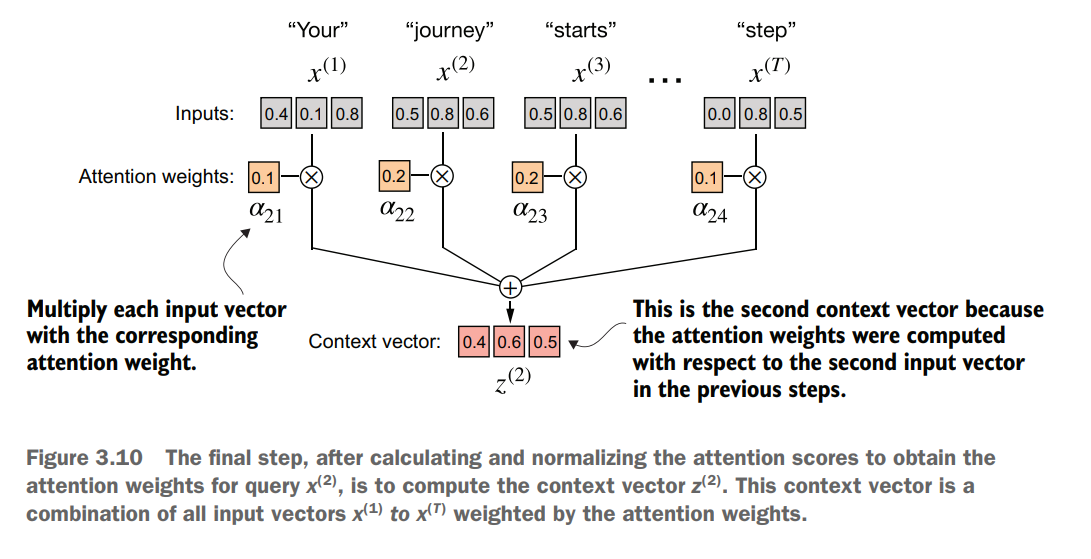

In [15]:
all_context_vectorss = attn_weights @ inputs 
print(all_context_vectorss)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
